In [102]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
from collections import defaultdict
from causallearn.search.ConstraintBased.PC import pc as pc_alg 
from causallearn.utils.cit import chisq, fisherz
from causallearn.utils.GraphUtils import GraphUtils
import dowhy
from dowhy import CausalModel
import cdt 
from cdt.causality.graph import PC, LiNGAM, GES 
from IPython.display import SVG 
from sklearn.utils import check_array

import xgboost as xgb
from sklearn.model_selection import train_test_split 

from sklearn.metrics import mean_squared_error as MSE 
from sklearn import metrics
from xgboost import plot_importance
from sklearn.metrics import accuracy_score, classification_report

from sklearn.ensemble import RandomForestClassifier
import pylab as plt 

from graphviz import Source
import pydot

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import trange


In [ ]:
np.random.seed(42)

# Number of samples
n_samples = 1000

# Generate synthetic data for the specified columns
data = pd.DataFrame({
    'variation': np.random.poisson(1.5, n_samples),
    'activeness': np.random.rand(n_samples),
    'pure_shop': np.random.randint(0, 2, n_samples),
    'user_create_days': np.random.randint(30, 3650, n_samples),
    'days_since_first_video': np.random.randint(0, 1000, n_samples),
    'days_since_first_live': np.random.randint(0, 1000, n_samples),
    'ecom_live_cnt': np.random.poisson(5, n_samples),
    'ecom_video_cnt': np.random.poisson(10, n_samples),
    'video_cnt': np.random.poisson(20, n_samples),
    'live_duration': np.random.exponential(30, n_samples),
    'fans_num': np.random.randint(0, 1000000, n_samples),
    'author_level': np.random.randint(1, 6, n_samples),
    'cl_amt_30d': np.random.uniform(0, 100000, n_samples),
    'ad_ratio': np.random.rand(n_samples),
    'search_ratio': np.random.rand(n_samples),
    'ad_pv': np.random.randint(0, 100000, n_samples),
    'follow_ratio': np.random.rand(n_samples)
})

In [85]:
pd.options.display.max_columns = None 
#data = res[(res.increase==0)&(res.decrease==0)]
remain_cols = ['variation', 'activeness', 'pure_shop', 'user_create_days',
               'days_since_first_video', 'days_since_first_live', 'ecom_live_cnt', 'ecom_video_cnt',
               'video_cnt', 'live_duration', 'fans_num', 'author_level', 'cl_amt_30d', 'ad_ratio',
               'search_ratio', 'ad_pv', 'follow_ratio']

data['stability'] = 0
data.loc[data.variation>=2, 'stability'] = 1
data.drop('variation', axis = 1, inplace = True)


In [86]:
data['stability'].nunique

<bound method IndexOpsMixin.nunique of 0      1
1      0
2      0
3      0
4      1
      ..
995    1
996    0
997    1
998    1
999    1
Name: stability, Length: 1000, dtype: int64>

In [38]:
### Prediction Model 
X = data[[i for i in data.columns if i not in ['activeness']]]
Y = data[['activeness']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=29)
model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=5, 
                         min_child_weight=1, subsample=0.6, colsample_bytree=0.6, eval_metric='rmse')
model.fit(X_train, y_train)

test_pred_xgb = model.predict(X_test)
train_pred_xgb = model.predict(X_train)

test_rmse_xgb = np.sqrt(MSE(y_test, test_pred_xgb))
train_rmse_xgb = np.sqrt(MSE(y_train, train_pred_xgb))
print("Xgb Test Sets RMSE : % f; \nXgb Train Sets RMSE : % f" %(test_rmse_xgb, train_rmse_xgb))

Xgb Test Sets RMSE :  0.314935; 
Xgb Train Sets RMSE :  0.000489


In [39]:
test_R2, train_R2 = metrics.r2_score(y_test, test_pred_xgb), metrics.r2_score(y_train, train_pred_xgb)
test_R2, train_R2 

(-0.1989659070968628, 0.9999971389770508)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

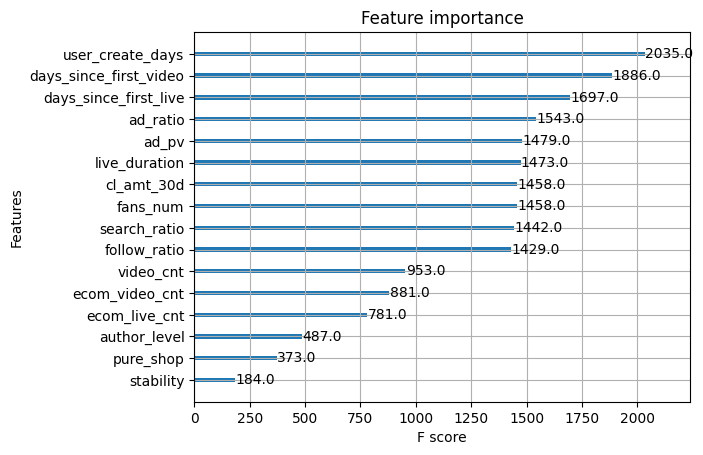

In [40]:
plot_importance(model, max_num_features=20)

In [41]:
X = data[[i for i in data.columns if i not in ['activeness', 'stability']]]
Y = data[['stability']]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=29)

In [42]:
model_t = xgb.XGBClassifier(learning_rate=0.08, n_estimators=1000, max_depth=5,
                            min_child_weight=1, subsample=0.6, colsample_bytree=0.6, objective = 'binary:logistic',
                            eval_metric = 'logloss', nthread=4, scale_pos_weight=1,use_label_encoder=False
                            )
model_t.fit(X_train, y_train)
y_pred = model_t.predict(X_test)
predictions = [int(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, predictions))

Accuracy: 48.50%
              precision    recall  f1-score   support

           0       0.50      0.58      0.53       102
           1       0.47      0.39      0.42        98

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.48      0.48      0.48       200



<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

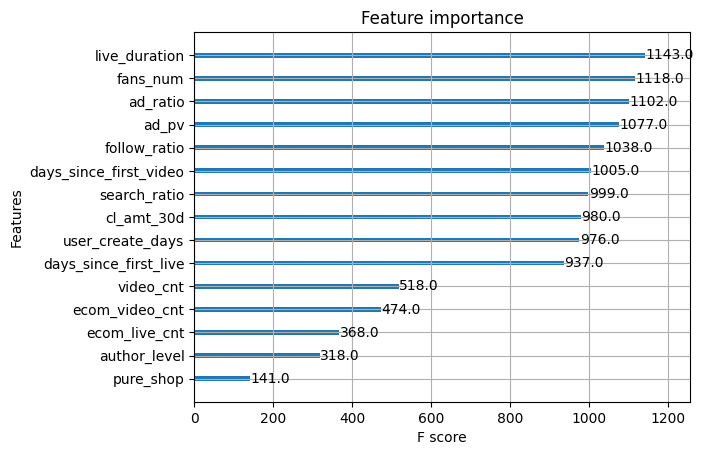

In [43]:
plot_importance(model_t, max_num_features=20)

In [87]:
pd.options.display.max_columns = None 
#data = res[(res.increase==0)&(res.decrease==0)]
data_cd = data


In [88]:
rename_d = {'stability': 'stability_p2',
            'pure_shop': 'pure_shop_p0',
            'days_since_first_video': 'days_since_first_video_p0',
            'days_since_first_live': 'days_since_first_live_p0',
            'user_create_days': 'user_create_days_p0',
            'ecom_live_cnt': 'ecom_live_cnt_p1',
            'ecom_video_cnt': 'ecom_video_cnt_p1',
            'video_cnt': 'video_cnt_p1',
            'live_duration': 'live_duration_p1',
            'fans_num': 'fans_num_p0',
            'author_level': 'author_level_p0',
            'cl_amt_30d': 'cl_amt_30d_p0',
            'ad_pv': 'ad_pv_p1',
            'ad_ratio': 'ad_ratio_p1',
            'follow_ratio': 'follow_ratio_p1',
            'search_ratio': 'search_ratio_p1',
            'activeness': 'activeness_p3'}
data_cd = data_cd.rename(columns=rename_d)
#data_cd.drop(['increase', 'decrease'], axis=1, inplace=True)

In [89]:
label_dict = {f"X{i+1}": data_cd.columns[i] for i in range(len(data_cd.columns))}
label_dict

{'X1': 'activeness_p3',
 'X2': 'pure_shop_p0',
 'X3': 'user_create_days_p0',
 'X4': 'days_since_first_video_p0',
 'X5': 'days_since_first_live_p0',
 'X6': 'ecom_live_cnt_p1',
 'X7': 'ecom_video_cnt_p1',
 'X8': 'video_cnt_p1',
 'X9': 'live_duration_p1',
 'X10': 'fans_num_p0',
 'X11': 'author_level_p0',
 'X12': 'cl_amt_30d_p0',
 'X13': 'ad_ratio_p1',
 'X14': 'search_ratio_p1',
 'X15': 'ad_pv_p1',
 'X16': 'follow_ratio_p1',
 'X17': 'stability_p2'}

In [ ]:
from pycausal import prior as p
forbid = [['ad_ratio_p1', 'ad_pv_p1']]
temporal = [
    ['pure_shop_p0', 'user_create_days_p0', 'days_since_first_video_p0', 'days_since_first_live_p0', 'fans_num_p0', 'author_level_p0', 'cl_amt_30d_p0'], #控制期之前
    ['ecom_live_cnt_p1', 'ecom_video_cnt_p1', 'video_cnt_p1', 'live_duration_p1', 'ad_ratio_p1', 'search_ratio_p1', 'ad_pv_p1', 'follow_ratio_p1'], #控制期
    ['stability_p2'],
    ['activeness_p3']
]
prior = p.knowledge(forbiddirect = forbid,
                    addtemporal = temporal)

NameError: name 'p' is not defined

In [ ]:
from pycausal import search as s
tetrad = s.tetradrunner()
tetrad.run(algoId = 'fges', dfs = data_cd, priorKnowledge = prior, 
           maxDegree = -1, faithfulnessAssumed = True, verbose = True)

graph = tetrad.getTetradGraph()
print('Graph BIC {}'.format(graph.getAttribute('BIC')))
nodes = graph.getNodes()
for i in range(nodes.size()):
    node = nodes.get(i)
    print('Node {} BIC: {}'.format(node.getName(), node.getAttribute('BIC')))

ModuleNotFoundError: No module named 'pycausal'

In [71]:
dot_str = pc.tetradGraphToDot(tetrad.getTetradGraph())
Source(dot_str)

NameError: name 'pc' is not defined

In [72]:
def convert_pycausal_to_DoWhy(graph):
    tmp_graph='digraph{'
    for i in pc.extractTetradGraphNodes(graph):
        tmp_graph += "() [label = \"{}\"];\n".format(i,i)
    for i in pc.extractTetradGraphEdges(graph):
        i = i.replace("-->", "->")
        tmp_graph += "{};\n".format(i)
    final_graph = tmp_graph[0:-2]+'}'
    return(final_graph)

In [73]:
rm_bd_graph = ""
for i in convert_pycausal_to_DoWhy(graph).replace('---', '->').split("\n"):
    if 'label' in i:
        rm_bd_graph += i
        rm_bd_graph += '\n'
    else:
        rej_num = 0
        for j in ['user_create_days_p0', 'ad_ratio_p1', 'ecom_live_cnt_p1', 'author_level_p0', 'search_ratio_p1', 'ad_pv_p1']:
            if j in i:
                rej_num +=1
        if rej_num == 0:
            rm_bd_graph += i
            rm_bd_graph += '\n'
            
Source(rm_bd_graph[:-2]+'}').render('1', format = 'png', view = False)

NameError: name 'graph' is not defined

In [91]:
### Matching
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model
treatment = ['stability_p2']
outcome = ['activeness_p3']
bd_cols = ['ad_ratio_p1',
           'search_ratio_p1',
           'user_create_days_p0',
           'ecom_live_cnt_p1',
           'live_duration_p1',
           'pure_shop_p0',
           'author_level_p0',
           'days_since_first_video_p0',
           'days_since_first_live_p0',
           'ad_pv_p1'] #['user_create_days_p0', 'ad_ratio_p1', 'ecom_live_cnt_p1', 'author_level_p0', 'search_ratio_p1', 'ad_pv_p1', 'pure_shop_p0']
data_psm = data_cd[bd_cols + outcome + treatment]

# dummy_var = ['author_level_p0']
# for each in dummy_var:
#     dummies = pd.get_dummies(data_psm.loc[:, each], prefix = each, drop_first = True)
#     data_psm = pd.concat([data_psm, dummies], axis = 1)
# data = res[['']]
# data_psm.drop(dummy_var, axis=1, inplace=True)

propensity_score_model = xgb.XGBClassifier(learning_rate=1, n_estimator=100, max_depth = 5,
                                           min_child_weight = 1, subsample = 0.6, colsample_bytree = 0.6,
                                           objective = 'binary:logistic', eval_metric = 'logloss',
                                           nthread=4, scale_pos_weight=1, use_label_encoder=False)
# model_psm.fit(X_psm, y_psm) #linear_model.logisticRegression()

X_psm = data_psm[[i for i in data_psm.columns if i not in ['activeness_p3', 'stability_p2']]]
y_psm = data_psm[treatment]
propensity_score_model.fit(X_psm, y_psm)
data_psm["ps_score"] = propensity_score_model.predict_proba(X_psm)[:, 1]

treated = data_psm.loc[data_psm[treatment[0]] == 1]
control = data_psm.loc[data_psm[treatment[0]] == 0]
control_neighbors = (
    NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
    .fit(control["ps_score"].values.reshape(-1,1))
)
distances, indices = control_neighbors.kneighbors(treated["ps_score"].values.reshape(-1,1))

In [92]:
data_psm

,ad_ratio_p1,search_ratio_p1,user_create_days_p0,ecom_live_cnt_p1,live_duration_p1,pure_shop_p0,author_level_p0,days_since_first_video_p0,days_since_first_live_p0,ad_pv_p1,activeness_p3,stability_p2,ps_score
0,0.765804,0.217998,867,8,14.212051,0,1,129,951,85352,0.109264,1,0.991875
1,0.572473,0.557876,860,3,35.795042,0,3,757,731,67165,0.853962,0,0.007690
2,0.425449,0.466447,1217,9,69.266334,0,5,823,824,8634,0.439150,0,0.015949
3,0.744080,0.575769,2995,6,11.580982,0,2,571,755,68550,0.846969,0,0.000631
4,0.965824,0.550962,253,3,18.527176,1,5,790,351,10773,0.893090,1,0.999509
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.386456,0.162586,1127,3,12.478566,0,4,38,75,85600,0.286520,1,0.970441
996,0.753277,0.162832,3609,7,21.660939,1,5,983,675,10655,0.802640,0,0.002202
997,0.956676,0.890865,102,4,57.326768,0,5,800,501,41864,0.997238,1,0.958259
998,0.023378,0.076034,2385,2,30.795161,1,5,442,84,6410,0.030026,1,0.969009


Text(0.5, 0, 'Scores')

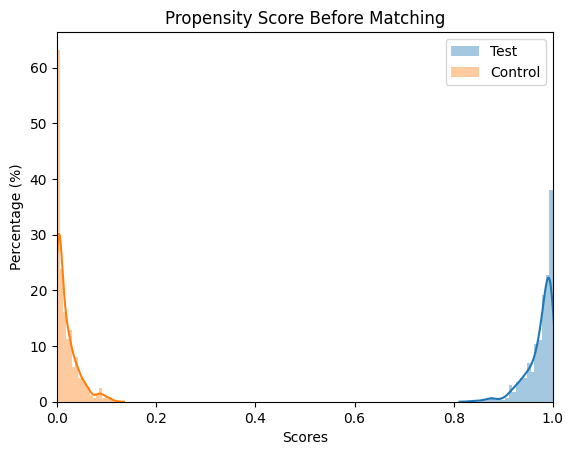

In [101]:
trt_cols = ['stability_p2']
test_scores = data_psm[data_psm[trt_cols].values.reshape(-1)==1][["ps_score"]]
ctrl_scores = data_psm[data_psm[trt_cols].values.reshape(-1)==0][["ps_score"]]

sns.distplot(test_scores, label = 'Test')
sns.distplot(ctrl_scores, label = 'Control')
plt.legend(loc = 'upper right')
plt.xlim((0,1))
plt.title("Propensity Score Before Matching")
plt.ylabel("Percentage (%)")
plt.xlabel("Scores")

In [ ]:
### Matching process
att = 0
numtreatedunits = treated.shape[0]
result, match_ids = [], []
threshold = 999 #1e-4

for i in trange(numtreatedunits):
    matched_id = i
    if distances[i][0] <= threshold:
        treated_outcome = treated.iloc[i]["activeness_p3"].item()
        control_outcome = control.iloc[indices[i]]["activeness_p3"].item()
        att += treated_outcome - control_outcome
        chosen = control.iloc[indices[i]].index[0] #indices[i] #np.random.choice(matches.index, 1, replace = False)
        result.extend([treated.index[i]] + [chosen])
        match_ids.extend([i]*2)
    else:
        continue

att /= numtreatedunits
matched_data = data_psm.loc[result]
matched_data['match_id'] = match_ids
matched_data['record_id'] = matched_data.index

100%|██████████| 450/450 [00:00<00:00, 6332.26it/s]


Text(0.5, 0, 'Scores')

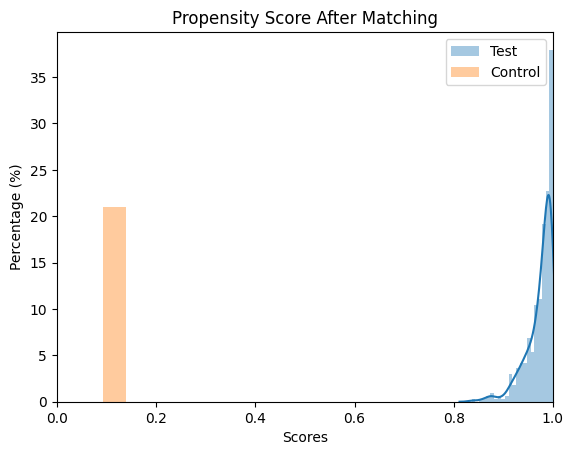

In [106]:
### PS plot after matching
trt_cols = ['stability_p2']
test_scores = matched_data[matched_data[trt_cols].values.reshape(-1)==1][["ps_score"]]
ctrl_scores = matched_data[matched_data[trt_cols].values.reshape(-1)==0][["ps_score"]]

sns.distplot(test_scores, label = 'Test')
sns.distplot(ctrl_scores, label = 'Control')
plt.legend(loc = 'upper right')
plt.xlim((0,1))
plt.title("Propensity Score After Matching")
plt.ylabel("Percentage (%)")
plt.xlabel("Scores")

(-0.85, 0.85)

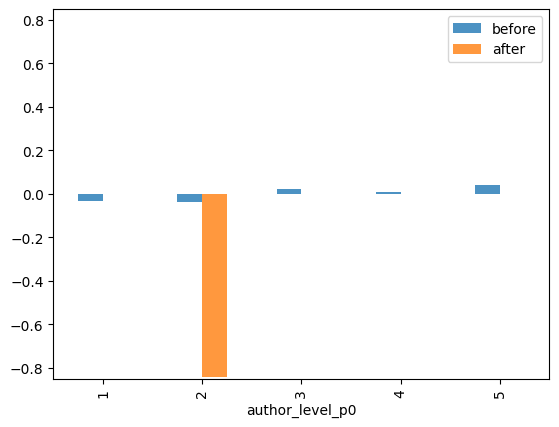

In [109]:
### Balance Check
## categorical 
from collections import Counter
from itertools import chain 

outcome_cols = ['activeness_p3']
trt_cols = ['stability_p2']
def prep_plot(data, var, colname):
    t, c = data[data[trt_cols].values.reshape(-1) == 1], data[data[trt_cols].values.reshape(-1) == 0]
    # dummy var counting
    dummy = [i for i in t.columns if i not in \
        (var, "match_id", "record_id", "weight")][0]
    # print(dummy)
    countt = t[[var, dummy]].groupby(var).count() / len(t)
    countc = c[[var, dummy]].groupby(var).count() / len(c)
    ret = (countt - countc).dropna()
    ret.columns = [colname]
    return ret 

dbefore = prep_plot(data_psm, 'author_level_p0', colname = 'before')
dafter = prep_plot(matched_data, 'author_level_p0', colname = 'after')
df = dbefore.join(dafter)

def prep_prop_test(data, var):
    counts = data.groupby([var]+trt_cols).count().reset_index()
    table = []
    for t in (0, 1):
        os_counts = counts[counts[trt_cols].values.reshape(-1) == t].sort_values(var)
        cdict = {}
        for row in os_counts.iterrows():
            row = row[1]
            cdict[row[var]] = row[2]
        table.append(cdict)
    
    #fill empty keys as 0
    all_keys = set(chain.from_iterable(table))
    for d in table:
        d.update((k, 0) for k in all_keys if k not in d)
    ctable = [[i[k] for k in sorted(all_keys)] for i in table]
    return ctable 

prep_prop_test(data_psm, 'author_level_p0')
df.plot.bar(alpha = .8)
#plt.title(title_str.format(col, test_results_i["before"],
#                           test_results_i["after"]))
lim = max(.09, abs(df).max().max()) + .01
plt.ylim((-lim, lim))

In [114]:
### continuous var balance check
from statsmodels.distributions.empirical_distribution import ECDF 

def std_diff(a, b):
    sd = np.std(pd.concat([a, b]))
    med = (np.median(a) - np.median(b)) * 1.0 / sd
    mean = (np.mean(a) - np.mean(b)) * 1.0 / sd
    SMD = abs(np.mean(a) - np.mean(b)) / np.sqrt((np.var(a) + np.var(b))/2)
    return med, mean, SMD 

col = 'day_since_first_live_p0'
def compare_continuous(data_psm, matched_data, col):
    test = data_psm[data_psm[trt_cols].values.reshape(-1)==1]
    ctrl = data_psm[data_psm[trt_cols].values.reshape(-1)==0]
    
    trb, cob = test[col], ctrl[col]
    tra = matched_data[matched_data[trt_cols].values.reshape(-1)==True][col]
    coa = matched_data[matched_data[trt_cols].values.reshape(-1)==False][col]
    xtb, xcb = ECDF(trb), ECDF(cob)
    xta, xca = ECDF(tra), ECDF(coa)
    std_diff_med_before, std_diff_mean_before, SMD_before = std_diff(trb, cob)
    std_diff_med_after, std_diff_mean_after, SMD_after = std_diff(tra, coa)
    
    #pb, truthb = grouped_permutation_test(chi2_distance, trb, cob)
    #pa, trutha = grouped_permutation_test(chi2_distance, tra, coa)
    #ksb = round(ks_boot(trb, cob, nboots=100), 6)
    #ksa = round(ks_boot(tra, coa, nboots=100), 6)
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(12,5))
    ax1.plot(xcb.x, xcb.y, label='Control', color='#1F77B4')
    ax1.plot(xtb.x, xtb.y, label='Test', color='#FF7F0E')
    title_str = '''
    ECDF for {} {} Matching
    SMD: {}
    Std. Median Difference: {}
    Std. Mean Difference: {}
    '''    
    ax1.set_title(title_str.format(col, "before", round(SMD_before,3),
                                   std_diff_med_before, std_diff_mean_before))
    ax2.set_title(title_str.format(col, "after", round(SMD_after,3),
                                   std_diff_med_after, std_diff_mean_after))
    ax2.plot(xca.x, xca.y, label='Control')
    ax2.plot(xtb.x, xtb.y, label='Test')

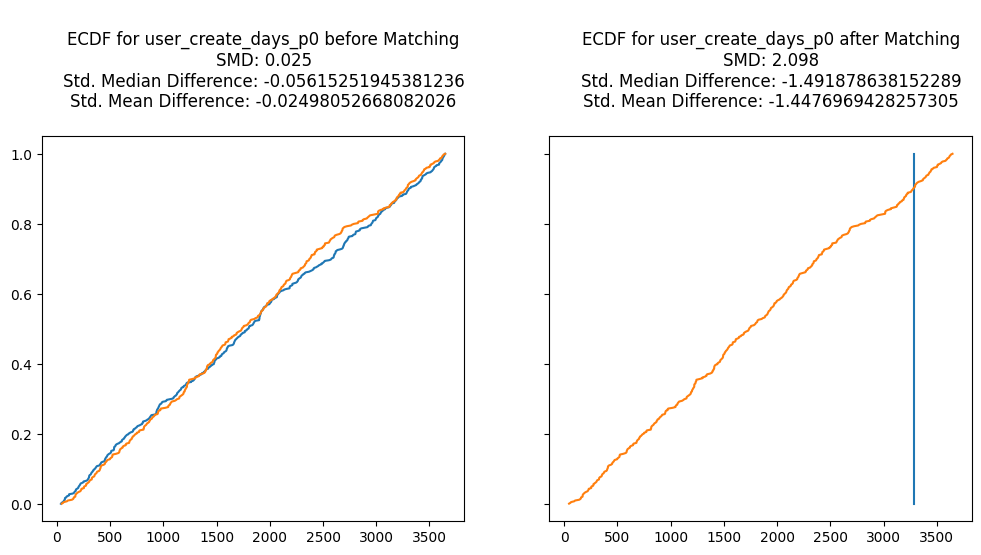

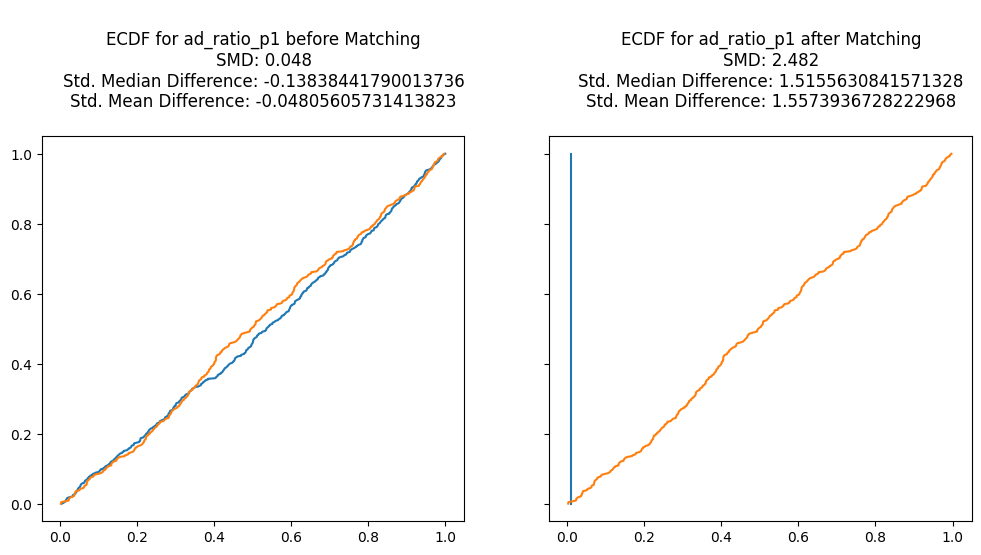

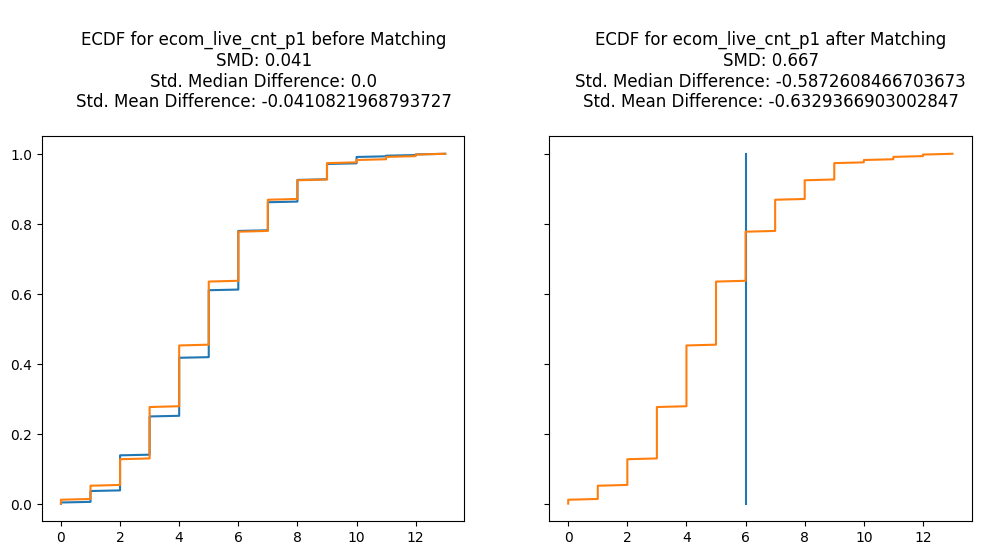

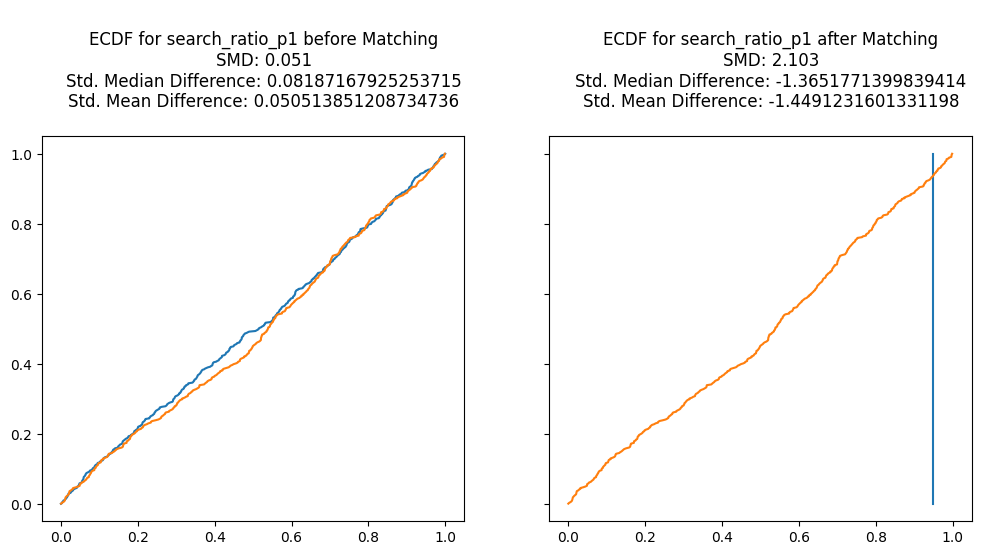

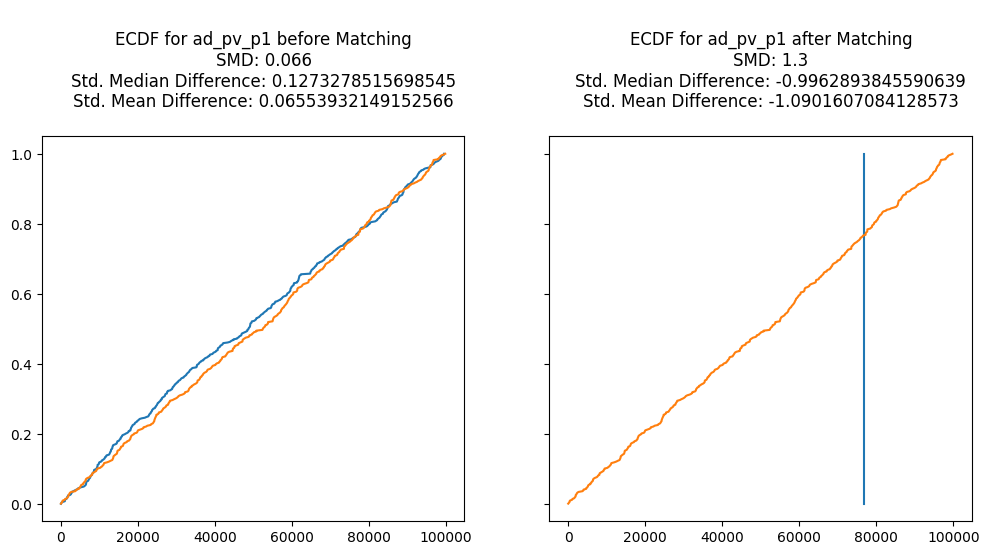

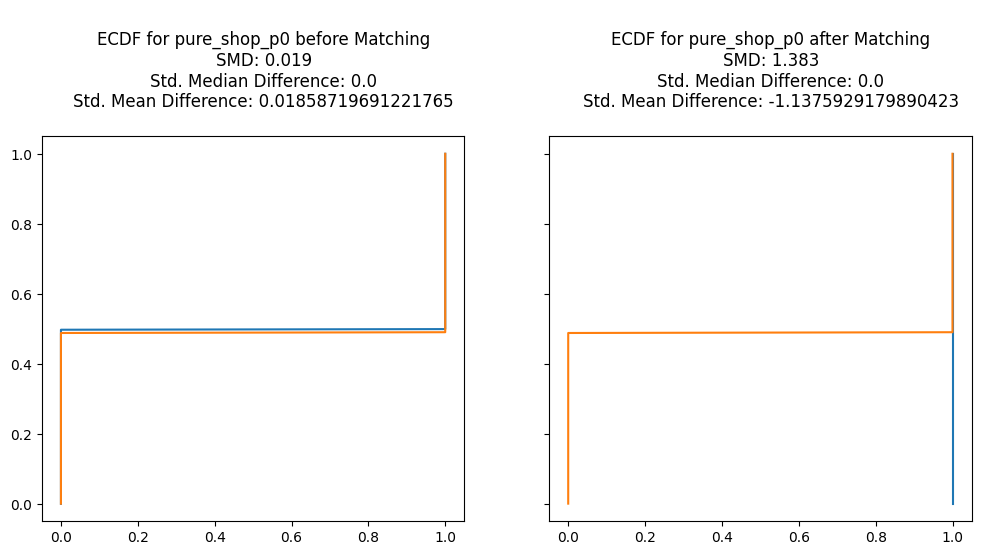

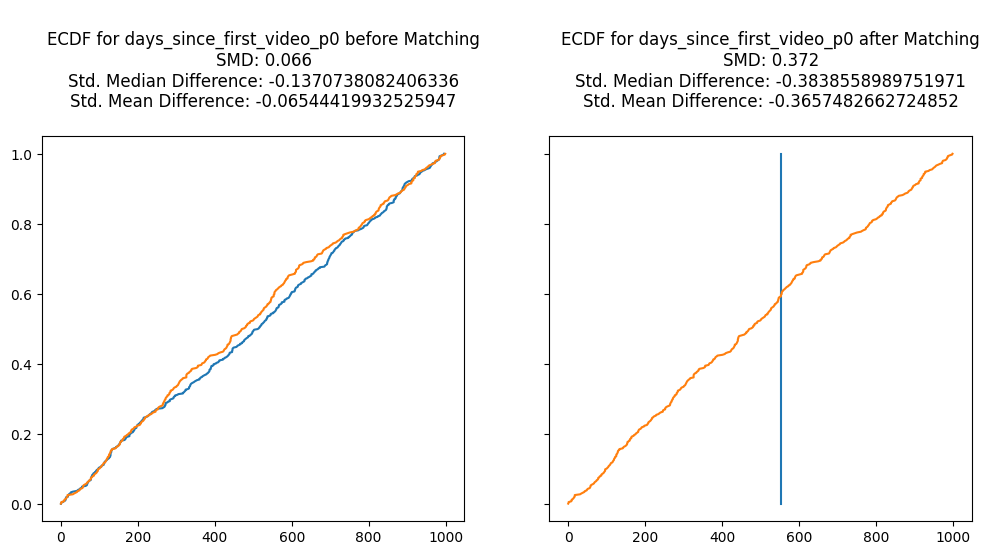

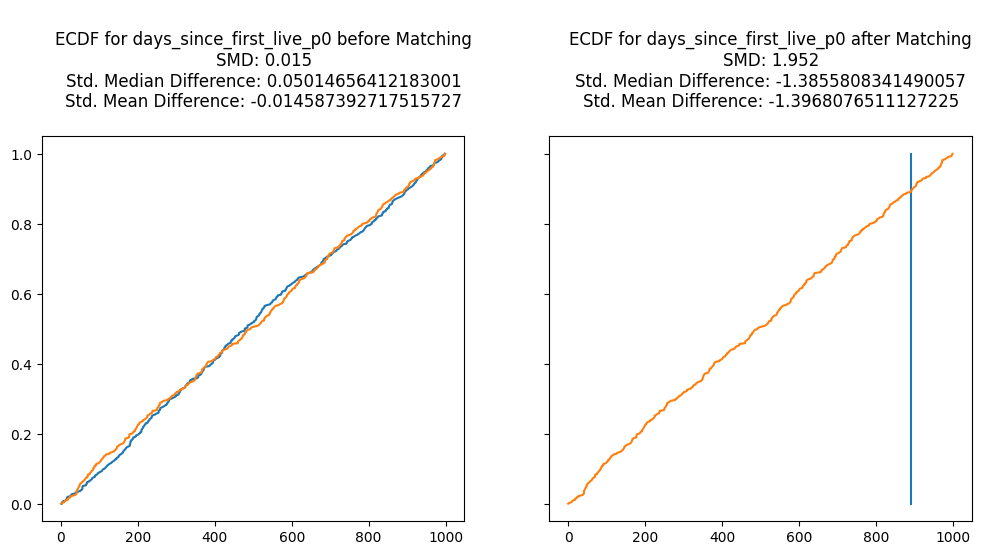

In [115]:
for i in ['user_create_days_p0', 'ad_ratio_p1', 'ecom_live_cnt_p1', 'search_ratio_p1', 'ad_pv_p1', 'pure_shop_p0', 'days_since_first_video_p0', 'days_since_first_live_p0']:
    compare_continuous(data_psm, matched_data, i)

In [117]:
from scipy import stats
import statsmodels.api as sm 
trt_y = matched_data.loc[matched_data.stability_p2 == 1, 'activeness_p3'].values 
ctrl_y = matched_data.loc[matched_data.stability_p2 == 0, 'activeness_p3'].values 
stats.levene(trt_y, ctrl_y)

LeveneResult(statistic=np.float64(1317.728841103406), pvalue=np.float64(2.6412832694517235e-178))

In [118]:
matched_data.groupby("stability_p2")['activeness_p3'].mean()

stability_p2
0    0.914549
1    0.493644
Name: activeness_p3, dtype: float64

In [119]:
data_cd.groupby("stability_p2")['activeness_p3'].mean()

stability_p2
0    0.507193
1    0.493644
Name: activeness_p3, dtype: float64

In [120]:
import statsmodels.stats.api as sms 
cm = sms.CompareMeans(sms.DescrStatsW(trt_y), sms.DescrStatsW(ctrl_y))
print(cm.tconfint_diff())
print(cm.ttest_ind()[1])
print(att)

(np.float64(-0.44764137670123133), np.float64(-0.39416820618443166))
2.266377920131231e-143
-0.4209047914428319


In [121]:
### Before Matching estimation
from scipy import stats
import statsmodels.api as sm 
trt_y = data_cd.loc[data_cd.stability_p2 == 1, 'activeness_p3'].values 
ctrl_y = data_cd.loc[data_cd.stability_p2 == 0, 'activeness_p3'].values 
stats.levene(trt_y, ctrl_y)

LeveneResult(statistic=np.float64(0.3494579815900846), pvalue=np.float64(0.5545539734177224))

In [122]:
import statsmodels.stats.api as sms 
cm = sms.CompareMeans(sms.DescrStatsW(trt_y), sms.DescrStatsW(ctrl_y))
print(cm.tconfint_diff())
print(cm.ttest_ind()[1])
print(att)

(np.float64(-0.04970427195499269), np.float64(0.022606830562239416))
0.4622946891023293
-0.4209047914428319


In [124]:
### Robustness Check
data_rob = data_psm.copy()
model = CausalModel(
    data = data_rob,
    treatment = 'stability_p2',
    outcome = 'activeness_p3',
    common_causes=['ad_ratio_p1',
           'search_ratio_p1',
           'user_create_days_p0',
           'ecom_live_cnt_p1',
           'live_duration_p1',
           'pure_shop_p0',
           'author_level_p0',
           'days_since_first_video_p0',
           'days_since_first_live_p0',
           'ad_pv_p1']
)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [125]:
identified_estimand.backdoor_variables['backdoor'] = ['ad_ratio_p1',
                                                      'search_ratio_p1',
                                                      'user_create_days_p0',
                                                      'ecom_live_cnt_p1',
                                                      'live_duration_p1',
                                                      'pure_shop_p0',
                                                      'author_level_p0',
                                                      'days_since_first_video_p0',
                                                      'days_since_first_live_p0',
                                                      'ad_pv_p1'
                                                      ]

In [126]:
data_rob

,ad_ratio_p1,search_ratio_p1,user_create_days_p0,ecom_live_cnt_p1,live_duration_p1,pure_shop_p0,author_level_p0,days_since_first_video_p0,days_since_first_live_p0,ad_pv_p1,activeness_p3,stability_p2,ps_score
0,0.765804,0.217998,867,8,14.212051,0,1,129,951,85352,0.109264,1,0.991875
1,0.572473,0.557876,860,3,35.795042,0,3,757,731,67165,0.853962,0,0.007690
2,0.425449,0.466447,1217,9,69.266334,0,5,823,824,8634,0.439150,0,0.015949
3,0.744080,0.575769,2995,6,11.580982,0,2,571,755,68550,0.846969,0,0.000631
4,0.965824,0.550962,253,3,18.527176,1,5,790,351,10773,0.893090,1,0.999509
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.386456,0.162586,1127,3,12.478566,0,4,38,75,85600,0.286520,1,0.970441
996,0.753277,0.162832,3609,7,21.660939,1,5,983,675,10655,0.802640,0,0.002202
997,0.956676,0.890865,102,4,57.326768,0,5,800,501,41864,0.997238,1,0.958259
998,0.023378,0.076034,2385,2,30.795161,1,5,442,84,6410,0.030026,1,0.969009


In [127]:
# compare_continous(data_psm, matched_data, "ecom_live_cnt_p1")
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching",
                                 target_units="att")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                        ↪
──────────────(E[activeness_p3|ecom_live_cnt_p1,pure_shop_p0,days_since_first_ ↪
d[stabilityₚ₂]                                                                 ↪

↪                                                                              ↪
↪ live_p0,days_since_first_video_p0,live_duration_p1,user_create_days_p0,ad_ra ↪
↪                                                                              ↪

↪                                                  
↪ tio_p1,search_ratio_p1,author_level_p0,ad_pv_p1])
↪                                                  
Estimand assumption 1, Unconfoundedness: If U→{stability_p2} and U→activeness_p3 then P(activeness_p3|stability_p2,ecom_live_cnt_p1,pure_shop_p0,days_since_first_live_p0,days_since_first_video_p0,liv

In [128]:
res_placebo = model.refute_estimate(identified_estimand, estimate, 
                                    method_name= "placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:-0.043539114336122266
New effect:8.253483378227412e-05
p value:0.96



In [129]:
res_random = model.refute_estimate(identified_estimand, estimate, 
                                    method_name= "random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:-0.043539114336122266
New effect:-0.04353911433612226
p value:1.0



In [130]:
res_subset = model.refute_estimate(identified_estimand, estimate, 
                                    method_name= "data_subset_refuter", subset_fraction = 0.8)
print(res_subset)

Refute: Use a subset of data
Estimated effect:-0.043539114336122266
New effect:-0.03225090140636258
p value:0.5



In [136]:
### Other Analysis
ps_diff_list = []
match_id_list = []
for i in matched_data.match_id.unique():
    trt_ps = matched_data[(matched_data.match_id == i) & (matched_data.stability_p2 == 1)].ps_score.values[0]
    ctrl_ps = matched_data[(matched_data.match_id == i) & (matched_data.stability_p2 == 0)].ps_score.values[0]
    if abs(trt_ps - ctrl_ps) >= 1e-3:
        match_id_list.append(i)
    ps_diff_list.append(trt_ps - ctrt_ps)

In [137]:
matched_data[matched_data.match_id.isin(match_id_list)]

,ad_ratio_p1,search_ratio_p1,user_create_days_p0,ecom_live_cnt_p1,live_duration_p1,pure_shop_p0,author_level_p0,days_since_first_video_p0,days_since_first_live_p0,ad_pv_p1,activeness_p3,stability_p2,ps_score,match_id,record_id
0,0.765804,0.217998,867,8,14.212051,0,1,129,951,85352,0.109264,1,0.991875,0,0
597,0.010175,0.947776,3286,6,32.761940,1,2,552,891,76759,0.914549,0,0.115826,0,597
4,0.965824,0.550962,253,3,18.527176,1,5,790,351,10773,0.893090,1,0.999509,1,4
597,0.010175,0.947776,3286,6,32.761940,1,2,552,891,76759,0.914549,0,0.115826,1,597
5,0.229206,0.960107,813,8,7.817600,0,1,614,971,17881,0.062458,1,0.998882,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597,0.010175,0.947776,3286,6,32.761940,1,2,552,891,76759,0.914549,0,0.115826,447,597
998,0.023378,0.076034,2385,2,30.795161,1,5,442,84,6410,0.030026,1,0.969009,448,998
597,0.010175,0.947776,3286,6,32.761940,1,2,552,891,76759,0.914549,0,0.115826,448,597
999,0.537915,0.801508,228,1,5.808737,0,5,17,48,60388,0.897366,1,0.967937,449,999


(array([  1.,   3.,   5.,   3.,  12.,  19.,  35.,  50.,  98., 224.]),
 array([0.72054678, 0.73690915, 0.75327158, 0.76963395, 0.78599638,
        0.80235875, 0.81872118, 0.83508354, 0.85144591, 0.86780834,
        0.88417071]),
 <BarContainer object of 10 artists>)

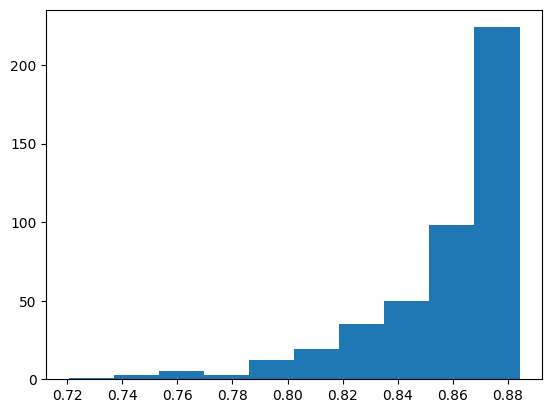

In [138]:
plt.hist(np.array(ps_diff_list))

In [139]:
sum(abs(np.array(ps_diff_list)) >= 1e-3)

np.int64(450)

In [142]:
### Matching process
def auto_matching(threshold):
    att = 0
    umtreatedunits = treated.shape[0]
    result, match_ids = [], []
    for i in trange(numtreatedunits):
        matched_id = i
        if distances[i][0] <= threshold:
            treated_outcome = treated.iloc[i]["activeness_p3"].item()
            control_outcome = control.iloc[indices[i]]["activeness_p3"].item()
            att += treated_outcome - control_outcome
            chosen = control.iloc[indices[i]].index[0] #indices[i] #np.random.choice(matches.index, 1, replace = False)
            result.extend([treated.index[i]] + [chosen])
            match_ids.extend([i]*2)
        else:
            continue

    att /= numtreatedunits
    matched_data = data_psm.loc[result]
    matched_data['match_id'] = match_ids
    matched_data['record_id'] = matched_data.index
    xtb, xta = ECDF(data_psm[data_psm.stability_p2 == 1].activeness_p3), ECDF(matched_data.activeness_p3)
    plt.plot(xtb.x, xtb.y, label = 'before', color = "#1F77B4")
    plt.plot(xta.x, xta.y, label = 'after', color = '#FF7F0E')
    plt.legend(loc = 'upper right')
    return(att)


In [143]:
auto_matching(1e-6)

100%|██████████| 450/450 [00:00<00:00, 805220.48it/s]


ZeroDivisionError: float division by zero

In [ ]:
#### Other Estimation Method
### Propensity stratification
data_rob = data_psm.copy()
model = CausalModel(
    data = data_rob,
    treatment = 'stability_p2',  
    outcome = 'activeness_p3',
    common_causes=['ad_ratio_p1',
           'search_ratio_p1',
           'user_create_days_p0',
           'ecom_live_cnt_p1',
           'live_duration_p1',
           'pure_shop_p0',
           'author_level_p0',
           'days_since_first_video_p0',
           'days_since_first_live_p0',
           'ad_pv_p1']
)
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

causal_estimate_strat = model.estimate_effect(identified_estimand, 
                                              method_name = 'backdoor.propensity_score_stratification',
                                              target_units = 'att',
                                              method_params={'propensity_score_model': xgb.XGBClassifier(learning_rate = 1, n_estimators = 100, max_depth = 5, min_child_weight = 1, subsample = 0.6,
                                                                                                         colsample_bytree = 0.6, objective = 'binary:logistic', eval_metric = 'logloss',
                                                                   nthread = 4, scale_pos_weight = 1, use_label_encoder = False)})


ValueError: Not enough data to generate at least two strata. This error may be due to a high value of 'clipping_threshold'.

<Axes: ylabel='Density'>

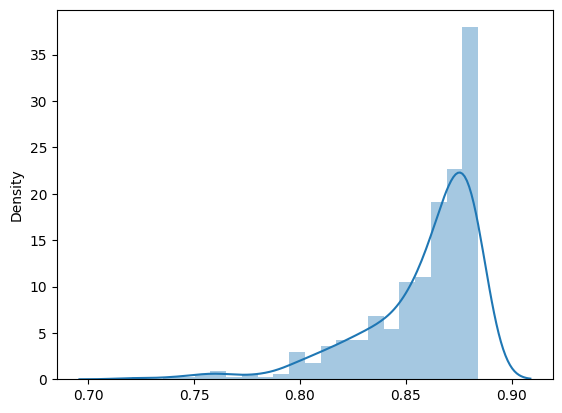

In [141]:
sns.distplot(ps_diff_list, label='Test')